In [1]:
import numpy as np 
import pandas as pd 
import os
from sklearn.feature_selection import mutual_info_classif, SelectKBest, chi2
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, accuracy_score, pairwise_distances, log_loss, average_precision_score, confusion_matrix
from scipy.spatial.distance import squareform
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.utils import check_random_state
import random
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
import shap
from imblearn.over_sampling import SMOTE, RandomOverSampler
from scipy.stats import entropy

seed = 42
np.random.seed(seed)
check_random_state(seed)
random.seed(seed)

In [2]:
df = pd.read_csv('/kaggle/input/playground-series-s3e13/train.csv').drop('id', axis = 1)

# Comparing clustering algorithms
## Minimizing average entropy

In [3]:
def build_freq(df):
    freq = pd.DataFrame(df[['cluster', 'prognosis']].value_counts())
    freq.columns = ['freq']
    freq = freq.reset_index()
    freq = freq.pivot(index=['prognosis'], columns='cluster', values= 'freq').fillna(0)
    freq = freq.apply(lambda x: x/sum(x), axis = 0)
    return freq

def calc_entropy(df):
    freq = build_freq(df)
    e_list = [entropy(freq[col], base = 2) for col in freq.columns]
    cluster_freq = [df[df['cluster'] == col].shape[0] for col in freq.columns]
    result = np.average(e_list, weights = cluster_freq)
    return result

Data was converted to boolean for metric jaccard


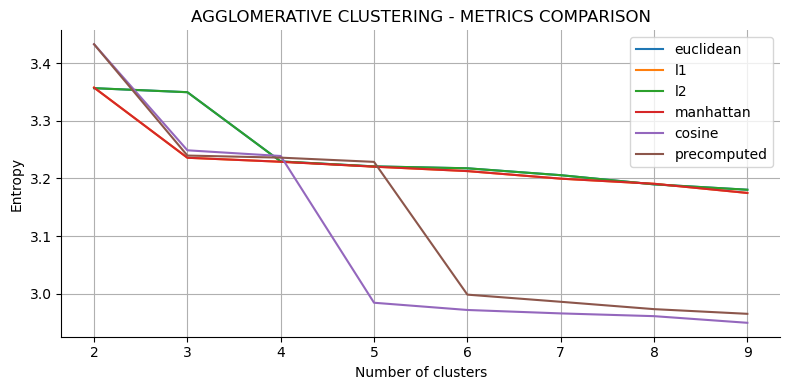

In [4]:
affinities = ['euclidean', 'l1', 'l2', 'manhattan', 'cosine', 'precomputed']

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))

try:
    X = df.drop(['prognosis', 'cluster'], axis = 1)
except:
    X = df.drop(['prognosis'], axis = 1)

for i, affinity in enumerate(affinities):
    calculated_entropies = []    
    input_set = X
    
    if affinity == 'precomputed':
        input_set = pairwise_distances(X.values, metric='jaccard')
        
    for n in range(2, 10):
        clustering = AgglomerativeClustering(n_clusters = n,
                               linkage = 'average',
                               affinity = affinity)

        clustering.fit(input_set)        
        labels = clustering.labels_
        
        df_copy = df.copy()
        df_copy['cluster'] = labels
        
        calculated_entropies.append(calc_entropy(df_copy))
    
    sns.lineplot(y = calculated_entropies, x = list(range(2, 10)), ax = ax, label = affinity)   
    

ax.set_ylabel('Entropy')
ax.set_xlabel('Number of clusters')
ax.set_title(f'Agglomerative Clustering - METRICS COMPARISON'.upper())
plt.grid(True)
sns.despine()
plt.tight_layout()
plt.show()

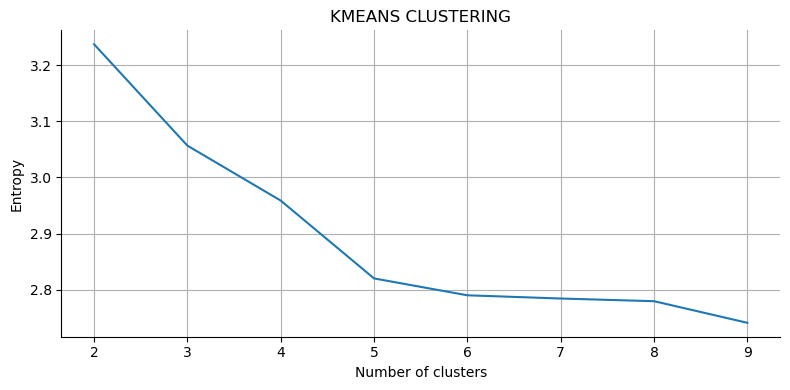

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))

try:
    X = df.drop(['prognosis', 'cluster'], axis = 1)
except:
    X = df.drop(['prognosis'], axis = 1)

calculated_entropies = []

for n_clusters in range(2, 10):
    clustering = KMeans(n_clusters=n_clusters, random_state=42)
    clustering.fit(X)
    
    labels = clustering.labels_        
    df_copy = df.copy()
    df_copy['cluster'] = labels

    calculated_entropies.append(calc_entropy(df_copy))
    
sns.lineplot(y = calculated_entropies, x = list(range(2, 10)), ax = ax)

ax.set_ylabel('Entropy')
ax.set_xlabel('Number of clusters')
ax.set_title(f'KMeans Clustering'.upper())
plt.grid(True)
sns.despine()
plt.tight_layout()
plt.show()

Data was converted to boolean for metric jaccard


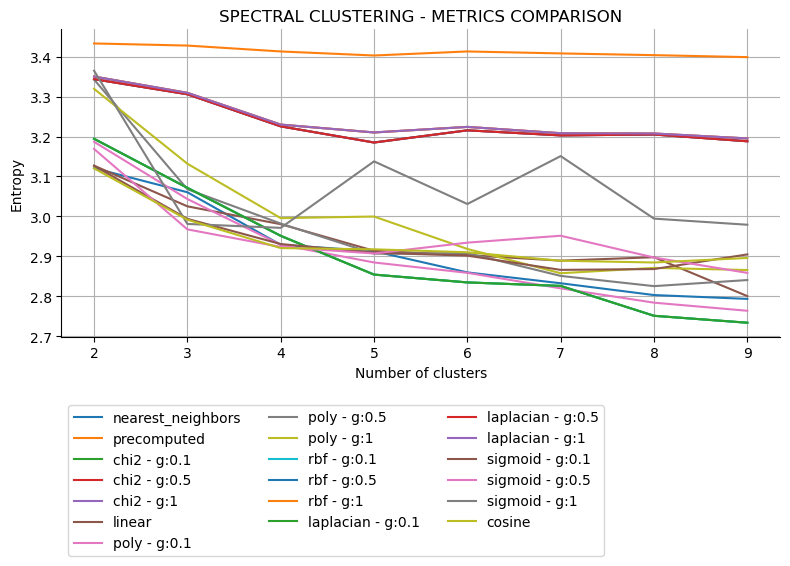

In [6]:
affinities = ['nearest_neighbors','precomputed',
           'chi2', 'linear', 'poly', 'rbf', 'laplacian', 
           'sigmoid', 'cosine']

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 5))

try:
    X = df.drop(['prognosis', 'cluster'], axis = 1)
except:
    X = df.drop(['prognosis'], axis = 1)

for i, affinity in enumerate(affinities):   
    input_set = X
    
    if affinity in ['rbf', 'poly', 'sigmoid', 'laplacian', 'chi2']:
        for gamma in [.1, .5, 1]:
            calculated_entropies = [] 
            for n in range(2, 10):
                clustering = SpectralClustering(n_clusters = n, random_state = 42, 
                                                gamma = gamma, affinity = affinity)
                clustering.fit(input_set)        
                labels = clustering.labels_

                df_copy = df.copy()
                df_copy['cluster'] = labels
                calculated_entropies.append(calc_entropy(df_copy))
            sns.lineplot(y = calculated_entropies, x = list(range(2, 10)), ax = ax, label = f'{affinity} - g:{gamma}')
        
    else:
        calculated_entropies = [] 
        if affinity == 'precomputed':
            input_set = pairwise_distances(X.values, metric='jaccard')

        for n in range(2, 10):
            clustering = SpectralClustering(n_clusters = n, random_state = 42, affinity = affinity)
            clustering.fit(input_set)        
            labels = clustering.labels_

            df_copy = df.copy()
            df_copy['cluster'] = labels

            calculated_entropies.append(calc_entropy(df_copy))

        sns.lineplot(y = calculated_entropies, x = list(range(2, 10)), ax = ax, label = affinity)

ax.set_ylabel('Entropy')
ax.set_xlabel('Number of clusters')
ax.set_title(f'SPECTRAL CLUSTERING - METRICS COMPARISON'.upper())

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.2, box.width, box.height * 0.8])
ax.legend(loc='upper left', bbox_to_anchor=(0, -0.2), ncol=3)

plt.grid(True)
sns.despine()
plt.tight_layout()
plt.show()

# Clustering
## KMeans N = 5

In [7]:
try:
    X = df.drop(['prognosis', 'cluster'], axis = 1)
except:
    X = df.drop(['prognosis'], axis = 1)
    
clustering = KMeans(n_clusters = 5, random_state = 42)
clustering.fit(X)        
labels = clustering.labels_

df_copy = df.copy()
df_copy['cluster'] = labels

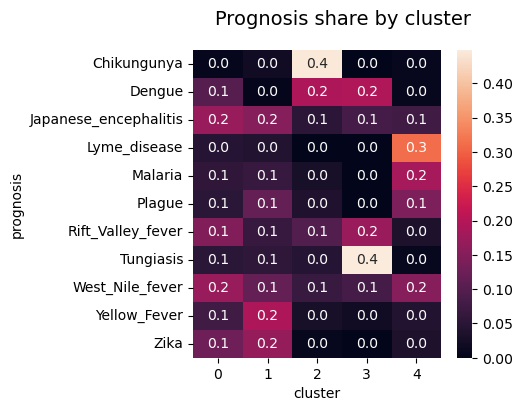

In [8]:
freq = build_freq(df_copy)
fig = plt.figure(figsize = (4,4))
ax = sns.heatmap(freq , annot = True, fmt = '.1f')
plt.suptitle('Prognosis share by cluster\n', fontsize = 14)
plt.show()

## Notes:

- The clusters explain the behavior we have seen in our classification results. Diseases such as Chikungunya, Tungiasis and Lyme disease are easily separable, while other like Japanese_encephatilis and West_Nile_fever are very difficult to identify.

### Cluster 0 - A complete mess
- Is the one with the most entropy, it is composed for small percentages of almost any disease.

### Cluster 1 -  The Yellow Fever + Zika cluster
- 60% of it is made of Japanese Encephalitis, Yellow Fever and Zika (the last two appearing almost exclusively here).
- Most Yellow Fever and Zika samples lie here.
- The other 40% are split between Malaria, Plague, Rift_Valley_Fever, Tungiasis and West_Nile_fever.

### Cluster 2 - The Chikungunya cluster
- Mostly composed by Chikungunya (40%) (almost all Chikungunya records fall on this group).
- Dengue comes in second place (20%).
- The other 30% is split between Japanese_encephalitis, Rift_Valley_fever and West_Nile_fever.

### Cluster 3 - The Tungiasis cluster
- Mostly composed by Tungiasis (40%).
- Dengue and Rift_Valley_fever come in seconds with 20% each.

### Cluster 4 - The Lime Disease cluster
- 30% of the samples are Lime_disease (almost all Lime_disease samples are here).
- 20% of the prognosis are Malaria and another 20% West_Nile_fever.



## Cluster samples count

In [9]:
df_copy['cluster'].value_counts()

1    197
0    158
2    135
4    119
3     98
Name: cluster, dtype: int64

### Symptoms occurrence by cluster

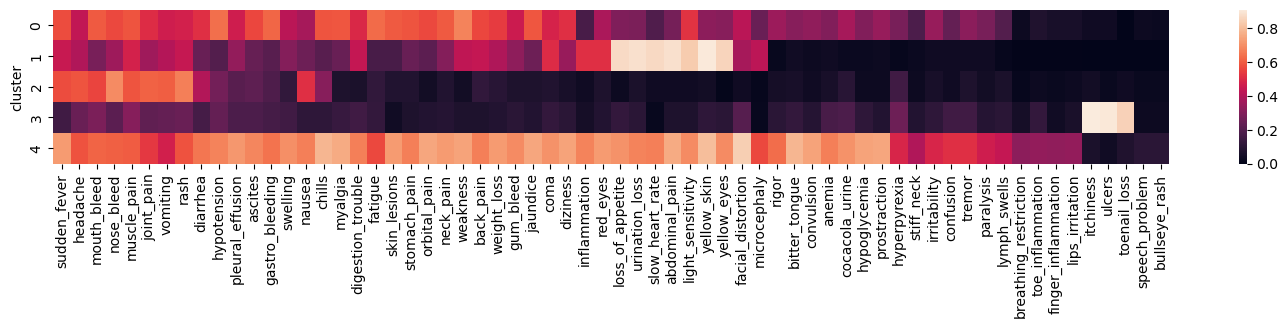

In [10]:
matrix = df_copy.groupby('cluster').mean()
fig = plt.figure(figsize = (18,2))
ax = sns.heatmap(matrix)
plt.show()

## Notes:
There are differences in the symptoms frequencies among the clusters.

For example:
- Cluster 3 - The Tungiasis cluster, is the only one with significant incidence of itchiness, ulcers and toenail_loss.